In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

def get_word_pairs_by_hungarian(AX, BY_aligned, words_en, words_es):
    # AX, BY_aligned: n x d
    from scipy.spatial.distance import cdist
    C = cdist(AX, BY_aligned, metric='euclidean')
    row_ind, col_ind = linear_sum_assignment(C)
    pred_pairs = [(words_en[i], words_es[j]) for i, j in zip(row_ind, col_ind)]
    return pred_pairs

def load_ground_truth_dict(filename):
    gt_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            en, es = line.strip().split()
            if en not in gt_dict:
                gt_dict[en] = set()
            gt_dict[en].add(es)
    return gt_dict



def compute_accuracy(pred_pairs, gt_dict):
    # only evaluate those in the dictionary
    valid = [(en,es) for en,es in pred_pairs if en in gt_dict]
    correct = sum(1 for en,es in valid if es in gt_dict[en])
    total   = len(valid)
    return correct/total, correct, total

from sklearn.metrics import pairwise_distances
import numpy as np

def recall_at_k(AX, BY_aligned, words_en, words_es, gt_dict, k=5):
    # Compute distance matrix (n_en, n_es)
    D = pairwise_distances(AX, BY_aligned, metric='euclidean')
    n = D.shape[0]
    correct = 0
    total = 0

    for i in range(n):
        en_word = words_en[i]
        if en_word not in gt_dict:
            continue  # skip if not in ground truth
        # Get top-k indices (smallest distances)
        topk_indices = np.argpartition(D[i], k)[:k]
        # What are their Spanish words?
        topk_es = {words_es[j] for j in topk_indices}
        # At least one match?
        if len(gt_dict[en_word] & topk_es) > 0:
            correct += 1
        total += 1
    recall = correct / total if total > 0 else 0.0
    print(f"Recall@{k}: {recall:.4f} ({correct} / {total})")
    return recall, correct, total

# -- Main workflow --
def main():
    # Load word embeddings
    with open('data/wiki.en.10k.vec', 'r', encoding='utf-8') as f_en, \
         open('data/wiki.es.10k.vec', 'r', encoding='utf-8') as f_es:
        words_en, X = read_vec(f_en)
        words_es, Y = read_vec(f_es)

    # Align by RISWIE
    AX, BY_aligned, row_ind, col_ind, matched_signs = align_by_riswie(X, Y, print_pairings=True)

    # Find pointwise matches (bijective) using Hungarian
    pred_pairs = get_word_pairs_by_hungarian(AX, BY_aligned, words_en, words_es)

    print("\nTop 100 Matched Pairs:")
    for idx, (en_word, es_word) in enumerate(pred_pairs[:100]):
        print(f"{idx+1:3d}: {en_word} ↔ {es_word}")

    # Score accuracy
    gt_dict = load_ground_truth_dict("data/en-es.0-6500.txt")
    accuracy, correct, total = compute_accuracy(pred_pairs, gt_dict)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({correct} / {total} correct)")

    recall_at_k(AX, BY_aligned, words_en, words_es, gt_dict, k=5)

        
def read_vec(file, dtype='float'):
    header = file.readline().split(' ')
    count = int(header[0])
    dim = int(header[1])
    words = []
    matrix = np.empty((count, dim), dtype=dtype)
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        words.append(word)
        matrix[i] = np.fromstring(vec, sep=' ', dtype=dtype)
    print(f"Finished reading. Matrix shape: {matrix.shape}")
    return words, matrix

if __name__ == '__main__':
    main()


Finished reading. Matrix shape: (10000, 300)
Finished reading. Matrix shape: (10000, 300)


KeyboardInterrupt: 

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

# --- RISWIE ALIGNMENT UTILITIES ---
def get_eigenbasis(X, k):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k)
    pca.fit(Xc)
    eigvecs = pca.components_.T   # shape: (d, k)
    eigvals = pca.explained_variance_
    return eigvecs, eigvals

def riswie_axis_matching(X, Y, k=2, verbose=False):
    # Center
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    eigvecs_X, _ = get_eigenbasis(Xc, k)
    eigvecs_Y, _ = get_eigenbasis(Yc, k)
    AX = Xc @ eigvecs_X  # n x k
    BY = Yc @ eigvecs_Y  # n x k

    # Cost and sign matrices for axis matching
    C = np.zeros((k, k))
    signs = np.zeros((k, k), dtype=int)
    for i in range(k):
        a_sorted = np.sort(AX[:, i])
        for j in range(k):
            b = BY[:, j]
            b_pos_sorted = np.sort(b)
            b_neg_sorted = np.sort(-b)
            d_pos = np.mean(np.abs(a_sorted - b_pos_sorted))
            d_neg = np.mean(np.abs(a_sorted - b_neg_sorted))
            if d_pos <= d_neg:
                C[i, j] = d_pos
                signs[i, j] = +1
            else:
                C[i, j] = d_neg
                signs[i, j] = -1

    # Optimal matching of axes (assignment problem)
    row_ind, col_ind = linear_sum_assignment(C)
    best_signs = [signs[i, j] for i, j in zip(row_ind, col_ind)]

    if verbose:
        print("RISWIE Axis Matchings:")
        for i, j, s in zip(row_ind, col_ind, best_signs):
            sign_txt = "+" if s > 0 else "-"
            print(f"  X_axis {i} ↔ {sign_txt}Y_axis {j}  (cost={C[i, j]:.4f})")

    return AX, BY, eigvecs_X, eigvecs_Y, row_ind, col_ind, best_signs

def compute_alignment_rotation(eigvecs_X, eigvecs_Y, row_ind, col_ind, best_signs, k):
    # Get axes and apply sign
    X_basis = eigvecs_X[:, row_ind]                      # (d, k)
    Y_basis = eigvecs_Y[:, col_ind] * best_signs         # (d, k)
    R = Y_basis @ X_basis.T
    return R

def align_by_riswie(X, Y, k=2, print_pairings=False):
    AX, BY, eigvecs_X, eigvecs_Y, row_ind, col_ind, best_signs = riswie_axis_matching(X, Y, k=k, verbose=print_pairings)
    R = compute_alignment_rotation(eigvecs_X, eigvecs_Y, row_ind, col_ind, best_signs, k)
    # Align Y: first center, then rotate
    Yc = Y - Y.mean(axis=0)
    BY_aligned = Yc @ R
    # Centered X, for matching in same space
    AX = X - X.mean(axis=0)
    return AX, BY_aligned, row_ind, col_ind, best_signs

# --- WORD PAIR MATCHING ---
def get_word_pairs_by_hungarian(AX, BY_aligned, words_en, words_es):
    from scipy.spatial.distance import cdist
    C = cdist(AX, BY_aligned, metric='euclidean')
    row_ind, col_ind = linear_sum_assignment(C)
    pred_pairs = [(words_en[i], words_es[j]) for i, j in zip(row_ind, col_ind)]
    return pred_pairs

def load_ground_truth_dict(filename):
    gt_dict = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            en, es = line.strip().split()
            if en not in gt_dict:
                gt_dict[en] = set()
            gt_dict[en].add(es)
    return gt_dict

def compute_accuracy(pred_pairs, gt_dict):
    valid = [(en,es) for en,es in pred_pairs if en in gt_dict]
    correct = sum(1 for en,es in valid if es in gt_dict[en])
    total   = len(valid)
    return correct/total if total > 0 else 0.0, correct, total

def recall_at_k(AX, BY_aligned, words_en, words_es, gt_dict, k=5):
    D = pairwise_distances(AX, BY_aligned, metric='euclidean')
    n = D.shape[0]
    correct = 0
    total = 0

    for i in range(n):
        en_word = words_en[i]
        if en_word not in gt_dict:
            continue
        topk_indices = np.argpartition(D[i], k)[:k]
        topk_es = {words_es[j] for j in topk_indices}
        if len(gt_dict[en_word] & topk_es) > 0:
            correct += 1
        total += 1
    recall = correct / total if total > 0 else 0.0
    print(f"Recall@{k}: {recall:.4f} ({correct} / {total})")
    return recall, correct, total

# --- MAIN WORKFLOW ---
def read_vec(file, dtype='float'):
    header = file.readline().split(' ')
    count = int(header[0])
    dim = int(header[1])
    words = []
    matrix = np.empty((count, dim), dtype=dtype)
    for i in range(count):
        word, vec = file.readline().split(' ', 1)
        words.append(word)
        matrix[i] = np.fromstring(vec, sep=' ', dtype=dtype)
    print(f"Finished reading. Matrix shape: {matrix.shape}")
    return words, matrix

def main():
    # Load word embeddings
    with open('data/wiki.en.10k.vec', 'r', encoding='utf-8') as f_en, \
         open('data/wiki.es.10k.vec', 'r', encoding='utf-8') as f_es:
        words_en, X = read_vec(f_en)
        words_es, Y = read_vec(f_es)

    # Align by RISWIE
    AX, BY_aligned, row_ind, col_ind, matched_signs = align_by_riswie(X, Y, k = min(X.shape[1], X.shape[0], Y.shape[1], Y.shape[0]), print_pairings=True)

    # Hungarian bijective matching
    pred_pairs = get_word_pairs_by_hungarian(AX, BY_aligned, words_en, words_es)

    print("\nTop 100 Matched Pairs:")
    for idx, (en_word, es_word) in enumerate(pred_pairs[:100]):
        print(f"{idx+1:3d}: {en_word} ↔ {es_word}")

    # Score accuracy
    gt_dict = load_ground_truth_dict("data/en-es.0-6500.txt")
    accuracy, correct, total = compute_accuracy(pred_pairs, gt_dict)
    print(f"\nOverall Accuracy: {accuracy:.4f} ({correct} / {total} correct)")

    recall_at_k(AX, BY_aligned, words_en, words_es, gt_dict, k=5)

if __name__ == '__main__':
    main()


Finished reading. Matrix shape: (10000, 300)
Finished reading. Matrix shape: (10000, 300)
RISWIE Axis Matchings:
  X_axis 0 ↔ +Y_axis 0  (cost=0.1664)
  X_axis 1 ↔ -Y_axis 1  (cost=0.0733)
  X_axis 2 ↔ +Y_axis 2  (cost=0.0594)
  X_axis 3 ↔ +Y_axis 3  (cost=0.0209)
  X_axis 4 ↔ -Y_axis 4  (cost=0.0280)
  X_axis 5 ↔ +Y_axis 5  (cost=0.0188)
  X_axis 6 ↔ -Y_axis 6  (cost=0.0339)
  X_axis 7 ↔ +Y_axis 7  (cost=0.0392)
  X_axis 8 ↔ +Y_axis 8  (cost=0.0258)
  X_axis 9 ↔ -Y_axis 9  (cost=0.0217)
  X_axis 10 ↔ +Y_axis 11  (cost=0.0140)
  X_axis 11 ↔ +Y_axis 10  (cost=0.0237)
  X_axis 12 ↔ +Y_axis 12  (cost=0.0295)
  X_axis 13 ↔ -Y_axis 14  (cost=0.0297)
  X_axis 14 ↔ -Y_axis 13  (cost=0.0358)
  X_axis 15 ↔ -Y_axis 15  (cost=0.0203)
  X_axis 16 ↔ +Y_axis 16  (cost=0.0090)
  X_axis 17 ↔ -Y_axis 20  (cost=0.0116)
  X_axis 18 ↔ +Y_axis 17  (cost=0.0108)
  X_axis 19 ↔ +Y_axis 18  (cost=0.0061)
  X_axis 20 ↔ -Y_axis 21  (cost=0.0058)
  X_axis 21 ↔ +Y_axis 23  (cost=0.0060)
  X_axis 22 ↔ -Y_axis 22  (

In [ ]:
# Quick check: How many unique English words in gold dict?
gt_dict = load_ground_truth_dict('data/en-es.0-6500.txt')
print("Number of English words in gold:", len(gt_dict))


Number of English words in gold: 6500


In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.csgraph import laplacian
from scipy.sparse.linalg import eigsh
from scipy.spatial.distance import cdist
import ot
from sklearn.decomposition import PCA

# ——— I/O ———————————————————————————————————————————————————————
def read_vec(f, dtype='float'):
    header = f.readline().split()
    n, d = map(int, header)
    words = []
    M = np.empty((n, d), dtype=dtype)
    for i in range(n):
        w, vec = f.readline().split(' ', 1)
        words.append(w)
        M[i] = np.fromstring(vec, sep=' ', dtype=dtype)
    print(f"Loaded {n}×{d}")
    return words, M

def load_ground_truth_dict(path):
    gt = {}
    for L in open(path, encoding='utf-8'):
        e, s = L.strip().split()
        gt.setdefault(e, set()).add(s)
    return gt

def score(pred, gt):
    c = sum(1 for e,s in pred if e in gt and s in gt[e])
    return c/len(pred), c, len(pred)

# ——— 1D-Wass utility —————————————————————————————————————————————
def get_sorted_columns(A):
    return [np.sort(A[:,i]) for i in range(A.shape[1])]

def w2_sq_1d(u_sorted, v_sorted):
    a = np.ones(len(u_sorted))/len(u_sorted)
    b = np.ones(len(v_sorted))/len(v_sorted)
    return ot.lp.emd2_1d(u_sorted, v_sorted, a, b)

# ——— Spectral embedding (or swap PCA) ————————————————————————————
def spectral_embed(X, k, n_neighbors=10, normalized=True):
    n, _ = X.shape
    G = kneighbors_graph(X, n_neighbors, include_self=True).astype(float)
    G = 0.5*(G+G.T)
    L = laplacian(G, normed=normalized)
    vals, vecs = eigsh(L, k=k+1, which='SM')
    idx = np.argsort(vals)
    vals, vecs = vals[idx], vecs[:,idx]
    return vecs[:,1:k+1], vals[1:k+1], vecs[:,1:k+1]

# ——— RISWIE axis match & cost —————————————————————————————————————
def riswie_match_cost(AX, BY):
    # AX, BY: (n, k)
    k = AX.shape[1]
    Acols = get_sorted_columns(AX)
    Bcols = get_sorted_columns(BY)
    C = np.zeros((k,k))
    for i in range(k):
        a = Acols[i]
        for j in range(k):
            b = Bcols[j]
            dpos = w2_sq_1d(a, b)
            dneg = w2_sq_1d(a, -b[::-1])
            C[i,j] = min(dpos, dneg)
    ri, ci = linear_sum_assignment(C)
    cost = C[ri,ci].sum()/k
    return cost, ri, ci

# ——— Ortho-align subclouds via RISWIE axes ——————————————————————————
def subcloud_align(Xc, Yc, k):
    """
    Given two centered subclouds Xc, Yc in R^d,
    (n_i x d) each, do PCA->RISWIE to get T in R^{dxd}.
    """
    n_i, d = Xc.shape

    # 1) run PCA in feature‐space so Ux,Uy ∈ R^{d × k}
    pcaX = PCA(n_components=k).fit(Xc)
    Ux = pcaX.components_.T            # shape (d, k)
    pcaY = PCA(n_components=k).fit(Yc)
    Uy = pcaY.components_.T            # shape (d, k)

    # 2) project to get 1D coords
    AX = Xc @ Ux                       # (n_i, k)
    BY = Yc @ Uy                       # (n_i, k)

    # 3) match axes via RISWIE
    _, ri, ci = riswie_match_cost(AX, BY)

    # 4) build signed permutation P,S in R^{k×k}
    P = np.zeros((k, k))
    S = np.zeros((k, k))
    for i, j in zip(ri, ci):
        P[i, j] = 1
        # pick sign by comparing the two 1D W2 costs
        a = np.sort(AX[:, i])
        b = np.sort(BY[:, j])
        if w2_sq_1d(a, b) <= w2_sq_1d(a, -b[::-1]):
            sgn = 1
        else:
            sgn = -1
        S[i, i] = sgn

    # 5) build the d×d orthogonal T
    T = Ux.dot(P.T).dot(S).dot(Uy.T)
    return T
# ——— Main pipeline —————————————————————————————————————————————
def main(
    en_path='data/wiki.en.10k.vec',
    es_path='data/wiki.es.10k.vec',
    gt_path='data/en-es.0-6500.txt',
    n_clusters=16,
    embed_dim=1000
):
    # 1) load
    words_en, X = read_vec(open(en_path,'r',encoding='utf-8'))
    words_es, Y = read_vec(open(es_path,'r',encoding='utf-8'))
    n = len(X)

    # 2) cluster each
    kmX = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
    kmY = KMeans(n_clusters=n_clusters, random_state=1).fit(Y)
    assignX = kmX.labels_
    assignY = kmY.labels_

    # 3) cost between every cluster pair
    Cc = np.zeros((n_clusters,n_clusters))
    for i in range(n_clusters):
        Xi = X[assignX==i]
        Xi = Xi - Xi.mean(0)
        for j in range(n_clusters):
            Yj = Y[assignY==j]
            Yj = Yj - Yj.mean(0)
            if len(Xi)>embed_dim and len(Yj)>embed_dim:
                cost,_,_ = riswie_match_cost(
                    spectral_embed(Xi,embed_dim)[0],
                    spectral_embed(Yj,embed_dim)[0]
                )
            else:
                cost = np.inf
            Cc[i,j]=cost

    # 4) match clusters
    rc, cc = linear_sum_assignment(Cc)

    # 5) within each matched pair do fine align+Hungarian
    pred = []
    for i,j in zip(rc,cc):
        Xi = X[assignX==i]; Yi = Y[assignY==j]
        ci = Xi.mean(0); cj = Yi.mean(0)
        Ti = subcloud_align(Xi-ci, Yi-cj, embed_dim)
        # transform Y→X
        Yi_al = (Yi-cj).dot(Ti.T) + ci
        # final Hungarian on points
        D = cdist(Xi, Yi_al)
        ri, ci2 = linear_sum_assignment(D)
        for a,b in zip(ri,ci2):
            pred.append(( words_en[np.where((X==Xi[a]).all(1))[0][0]],
                          words_es[np.where((Y==Yi[b]).all(1))[0][0]] ))

    # 6) evaluate
    gt = load_ground_truth_dict(gt_path)
    acc, corr, tot = score(pred, gt)

    print(f"Matched {len(pred)} words  →  Acc={acc:.4f} ({corr}/{tot})")
    for idx,(e,s) in enumerate(pred[:100],1):
        print(f"{idx:3d}: {e} ↔ {s}")

if __name__=='__main__':
    main()


Loaded 10000×300
Loaded 10000×300


ValueError: cost matrix is infeasible

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–embedding robustness experiment with RISWIE distance
===========================================================

Ten datasets := 5 clusters of English words  +  5 clusters of Spanish words
For each dataset build 10 graphs (4 k-NN, 3 r-NN, 3 ε graphs)
Compute spectral embeddings (d = 30)                   -> 100 embeddings
Compute 100×100 RISWIE distance matrix
For every graph pick its 9 nearest neighbours (exclude self) and
count how many belong to the same dataset (cluster) but use a different graph.
Return mean accuracy over 100 graphs.
"""

import os
import itertools
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, csgraph, diags
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

import ot  # POT library


# ---------------------------------------------------------------------
# I/O helpers ----------------------------------------------------------

def read_vec(path, dtype="float32"):
    """Read a .vec or .txt fastText file"""
    with open(path, "r", encoding="utf-8") as f:
        hdr = f.readline().split()
        n, dim = int(hdr[0]), int(hdr[1])
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat


# ---------------------------------------------------------------------
# Graph construction ---------------------------------------------------

def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False, metric="euclidean")
    A = 0.5 * (A + A.T)           # symmetrise
    return A.tocsr()

def radius_graph(X, radius):
    D = squareform(pdist(X, metric="euclidean"))
    A = (D <= radius).astype(float)
    np.fill_diagonal(A, 0.)
    return csr_matrix(A)

def epsilon_graph(X, epsilon):
    D = squareform(pdist(X, metric="euclidean"))
    W = np.exp(-(D**2) / (2*epsilon**2))
    W[D > 3*epsilon] = 0.                # sparsify far edges
    np.fill_diagonal(W, 0.)
    return csr_matrix(W)


# ---------------------------------------------------------------------
# Spectral embedding (Laplacian Eigenmaps) -----------------------------

def spectral_embed_graph(A, dim=30, normalised=True):
    """
    Return (n × dim) matrix of the first *dim* non-trivial eigenvectors.
    """
    # Compute Laplacian
    L = csgraph.laplacian(A, normed=normalised)
    n = L.shape[0]
    # Smallest (dim+1) eigenpairs (skip λ≈0 constant mode)
    vals, vecs = eigsh(L, k=dim+1, which="SM")
    idx = np.argsort(vals)        # ascending
    vals, vecs = vals[idx][1:], vecs[:, idx][:, 1:]
    return vecs, vals             # embedding, eigenvalues


# ---------------------------------------------------------------------
# RISWIE utilities -----------------------------------------------------

def _sorted_cols(M):
    return [np.sort(M[:, j]) for j in range(M.shape[1])]

def _w2_1d_sorted(u, v):
    n, m = len(u), len(v)
    a, b = np.ones(n)/n, np.ones(m)/m
    return ot.lp.emd2_1d(u, v, a, b)     # Wasserstein-2²

def riswie_distance(A, B):
    """
    Rigid-Invariant Sliced Wasserstein distance between two embeddings A,B
      A, B: (n × d) with same n and d
    Returns: scalar distance
    """
    d = A.shape[1]
    A_sorted, B_sorted = _sorted_cols(A), _sorted_cols(B)

    # Cost matrix over axes
    C = np.zeros((d, d))
    signs = np.ones((d, d))
    for i in range(d):
        u = A_sorted[i]
        for j in range(d):
            v = B_sorted[j]
            pos = _w2_1d_sorted(u, v)
            neg = _w2_1d_sorted(u, -v[::-1])
            if pos <= neg:
                C[i, j] = pos
                signs[i, j] = 1
            else:
                C[i, j] = neg
                signs[i, j] = -1

    ri, ci = linear_sum_assignment(C)
    cost = C[ri, ci].mean()               # mean squared Wasserstein
    return np.sqrt(cost)                  # RISWIE “distance”


# ---------------------------------------------------------------------
# Pipeline -------------------------------------------------------------

def build_all_graphs(cloud, recipe_id_list):
    """
    cloud: (n,d) numpy array
    recipe_id_list: list of 10 graph construction specs
    returns: list[csr_matrix]
    """
    graphs = []
    Dmat = squareform(pdist(cloud))
    med = np.median(Dmat[Dmat > 0])
    # compute radii percentiles
    dist_vals = Dmat[np.triu_indices_from(Dmat, k=1)]
    p5, p10, p20 = np.percentile(dist_vals, [5, 10, 20])

    for recipe in recipe_id_list:
        typ, param = recipe
        if typ == "knn":
            graphs.append(knn_graph(cloud, k=param))
        elif typ == "r":
            graphs.append(radius_graph(cloud, radius=param))
        elif typ == "eps":
            graphs.append(epsilon_graph(cloud, epsilon=param))
        else:
            raise ValueError(f"unknown recipe {recipe}")
    return graphs


def main():
    # --------------------------------------------------------------
    # 1) load embeddings (top-10k words each)
    en_words, X_en  = read_vec("data/wiki.en.10k.vec")
    es_words, X_es  = read_vec("data/wiki.es.10k.vec")

    # --------------------------------------------------------------
    # 2) k-means-5 clusters per language
    kmeans_en = KMeans(n_clusters=5, random_state=42).fit(X_en)
    kmeans_es = KMeans(n_clusters=5, random_state=42).fit(X_es)

    clusters = []        # list of (lang_tag, cluster_id, pointcloud)
    for cid in range(5):
        clusters.append(("EN", cid, X_en[kmeans_en.labels_ == cid]))
        clusters.append(("ES", cid, X_es[kmeans_es.labels_ == cid]))

    # --------------------------------------------------------------
    # 3) recipes: 10 graph constructions
    graph_recipes = [
        ("knn", 5), ("knn", 10), ("knn", 15), ("knn", 30),
        ("r",   None), ("r", None), ("r", None),          # placeholders – will be filled later
        ("eps", None), ("eps", None), ("eps", None)       # three ε graphs
    ]
    # we'll fill r- and eps- parameters inside build_all_graphs

    # --------------------------------------------------------------
    # 4) build graphs & spectral embeddings
    embeddings = []          # list of (dataset_id, graph_id, embedding (n×d))
    dataset_tags = []        # length-100 label (lang,cluster)
    global_idx = 0

    for ds_id, (lang, cid, cloud) in enumerate(clusters):
        # compute once the distance statistics for radius / ε graphs
        Dvals = pdist(cloud)
        p5, p10, p20 = np.percentile(Dvals, [5, 10, 20])
        med = np.median(Dvals)

        # clone recipes with concrete params
        concrete_recipes = [
            ("knn", 5), ("knn", 10), ("knn", 15), ("knn", 30),
            ("r", p5), ("r", p10), ("r", p20),
            ("eps", 0.6*med), ("eps", 0.8*med), ("eps", 1.0*med)
        ]

        graphs = build_all_graphs(cloud, concrete_recipes)

        for g_id, A in enumerate(graphs):
            emb, _ = spectral_embed_graph(A, dim=30, normalised=True)
            embeddings.append((ds_id, g_id, emb))
            dataset_tags.append(ds_id)
            global_idx += 1

    assert len(embeddings) == 100

    # --------------------------------------------------------------
    # 5) pairwise RISWIE distances
    n_graphs = len(embeddings)
    dist_mat = np.zeros((n_graphs, n_graphs))

    print("Computing 100 × 100 RISWIE distances …")
    for i, (_, _, Ei) in enumerate(tqdm(embeddings)):
        for j in range(i+1, n_graphs):
            Ej = embeddings[j][2]
            d = riswie_distance(Ei, Ej)
            dist_mat[i, j] = dist_mat[j, i] = d

    # --------------------------------------------------------------
    # 6) nearest-neighbour consistency score
    correct = 0
    for i in range(n_graphs):
        # indices sorted by distance (ascending), exclude self
        neighbours = np.argsort(dist_mat[i])[1:10]       # 9 nearest
        # how many share the same dataset id?
        same = sum(dataset_tags[j] == dataset_tags[i] for j in neighbours)
        correct += same

    accuracy = correct / (n_graphs * 9)
    print(f"\nNearest-neighbour consistency accuracy: {accuracy:.4f}")


# ---------------------------------------------------------------------
if __name__ == "__main__":
    main()


Computing 100 × 100 RISWIE distances …


100%|██████████| 100/100 [22:40<00:00, 13.60s/it]


Nearest-neighbour consistency accuracy: 0.3333


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–embedding robustness experiment with RISWIE distance
===========================================================

Ten datasets := 5 clusters of English words  +  5 clusters of Spanish words
For each dataset build 10 graphs (4 k-NN, 3 r-NN, 3 ε graphs)
Compute spectral embeddings (d = 30)                   -> 100 embeddings
Compute 100×100 RISWIE distance matrix
For every graph pick its 9 nearest neighbours (exclude self) and
count how many belong to the same dataset (cluster) but use a different graph.
Return mean accuracy over 100 graphs.
"""

import os
import itertools
import numpy as np
from collections import defaultdict
from tqdm import tqdm

from scipy.spatial.distance import pdist, squareform
from scipy.sparse import csr_matrix, csgraph, diags
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment

from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph

import ot  # POT library


# ---------------------------------------------------------------------
# I/O helpers ----------------------------------------------------------

def read_vec(path, dtype="float32"):
    """Read a .vec or .txt fastText file"""
    with open(path, "r", encoding="utf-8") as f:
        hdr = f.readline().split()
        n, dim = int(hdr[0]), int(hdr[1])
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat


# ---------------------------------------------------------------------
# Graph construction ---------------------------------------------------

def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False, metric="euclidean")
    A = 0.5 * (A + A.T)           # symmetrise
    return A.tocsr()

def radius_graph(X, radius):
    D = squareform(pdist(X, metric="euclidean"))
    A = (D <= radius).astype(float)
    np.fill_diagonal(A, 0.)
    return csr_matrix(A)

def epsilon_graph(X, epsilon):
    D = squareform(pdist(X, metric="euclidean"))
    W = np.exp(-(D**2) / (2*epsilon**2))
    W[D > 3*epsilon] = 0.                # sparsify far edges
    np.fill_diagonal(W, 0.)
    return csr_matrix(W)


# ---------------------------------------------------------------------
# Spectral embedding (Laplacian Eigenmaps) -----------------------------

def spectral_embed_graph(A, dim=30, normalised=True):
    """
    Return (n × dim) matrix of the first *dim* non-trivial eigenvectors.
    """
    # Compute Laplacian
    L = csgraph.laplacian(A, normed=normalised)
    n = L.shape[0]
    # Smallest (dim+1) eigenpairs (skip λ≈0 constant mode)
    vals, vecs = eigsh(L, k=dim+1, which="SM")
    idx = np.argsort(vals)        # ascending
    vals, vecs = vals[idx][1:], vecs[:, idx][:, 1:]
    return vecs, vals             # embedding, eigenvalues


# ---------------------------------------------------------------------
# RISWIE utilities -----------------------------------------------------

def _sorted_cols(M):
    return [np.sort(M[:, j]) for j in range(M.shape[1])]

def _w2_1d_sorted(u, v):
    n, m = len(u), len(v)
    a, b = np.ones(n)/n, np.ones(m)/m
    return ot.lp.emd2_1d(u, v, a, b)     # Wasserstein-2²

def riswie_distance(A, B):
    """
    Rigid-Invariant Sliced Wasserstein distance between two embeddings A,B
      A, B: (n × d) with same n and d
    Returns: scalar distance
    """
    d = A.shape[1]
    A_sorted, B_sorted = _sorted_cols(A), _sorted_cols(B)

    # Cost matrix over axes
    C = np.zeros((d, d))
    signs = np.ones((d, d))
    for i in range(d):
        u = A_sorted[i]
        for j in range(d):
            v = B_sorted[j]
            pos = _w2_1d_sorted(u, v)
            neg = _w2_1d_sorted(u, -v[::-1])
            if pos <= neg:
                C[i, j] = pos
                signs[i, j] = 1
            else:
                C[i, j] = neg
                signs[i, j] = -1

    ri, ci = linear_sum_assignment(C)
    cost = C[ri, ci].mean()               # mean squared Wasserstein
    return np.sqrt(cost)                  # RISWIE “distance”

def sliced_wasserstein_distance(A, B, n_proj=300, seed=0):
    """
    Computes Sliced Wasserstein-2 distance between two point clouds (can have different numbers of points).
    A: (n, d) numpy array
    B: (m, d) numpy array
    n_proj: number of random projection directions
    Returns: scalar SW2 distance
    """
    n, d = A.shape
    m, dB = B.shape
    assert d == dB
    rng = np.random.default_rng(seed)
    sw_vals = []
    for _ in range(n_proj):
        # Random unit vector in R^d
        v = rng.normal(size=(d,))
        v /= np.linalg.norm(v)
        # Project points
        proj_A = np.dot(A, v)
        proj_B = np.dot(B, v)
        # Sort projections
        proj_A.sort()
        proj_B.sort()
        # Wasserstein-2 (squared), allowing different sizes
        a = np.ones(n) / n
        b = np.ones(m) / m
        w2 = ot.lp.emd2_1d(proj_A, proj_B, a, b)
        sw_vals.append(w2)
    return np.sqrt(np.mean(sw_vals))   # Return SW2 (not squared)

# ---------------------------------------------------------------------
# Pipeline -------------------------------------------------------------

def build_all_graphs(cloud, recipe_id_list):
    """
    cloud: (n,d) numpy array
    recipe_id_list: list of 10 graph construction specs
    returns: list[csr_matrix]
    """
    graphs = []
    Dmat = squareform(pdist(cloud))
    med = np.median(Dmat[Dmat > 0])
    # compute radii percentiles
    dist_vals = Dmat[np.triu_indices_from(Dmat, k=1)]
    p5, p10, p20 = np.percentile(dist_vals, [5, 10, 20])

    for recipe in recipe_id_list:
        typ, param = recipe
        if typ == "knn":
            graphs.append(knn_graph(cloud, k=param))
        elif typ == "r":
            graphs.append(radius_graph(cloud, radius=param))
        elif typ == "eps":
            graphs.append(epsilon_graph(cloud, epsilon=param))
        else:
            raise ValueError(f"unknown recipe {recipe}")
    return graphs


def main():
    # --------------------------------------------------------------
    # 1) load embeddings (top-10k words each)
    en_words, X_en  = read_vec("data/wiki.en.10k.vec")
    es_words, X_es  = read_vec("data/wiki.es.10k.vec")

    # --------------------------------------------------------------
    # 2) k-means-5 clusters per language
    kmeans_en = KMeans(n_clusters=5, random_state=42).fit(X_en)
    kmeans_es = KMeans(n_clusters=5, random_state=42).fit(X_es)

    clusters = []        # list of (lang_tag, cluster_id, pointcloud)
    for cid in range(5):
        clusters.append(("EN", cid, X_en[kmeans_en.labels_ == cid]))
        clusters.append(("ES", cid, X_es[kmeans_es.labels_ == cid]))

    # --------------------------------------------------------------
    # 3) recipes: 10 graph constructions
    graph_recipes = [
        ("knn", 5), ("knn", 10), ("knn", 15), ("knn", 30),
        ("r",   None), ("r", None), ("r", None),          # placeholders – will be filled later
        ("eps", None), ("eps", None), ("eps", None)       # three ε graphs
    ]
    # we'll fill r- and eps- parameters inside build_all_graphs

    # --------------------------------------------------------------
    # 4) build graphs & spectral embeddings
    embeddings = []          # list of (dataset_id, graph_id, embedding (n×d))
    dataset_tags = []        # length-100 label (lang,cluster)
    global_idx = 0

    for ds_id, (lang, cid, cloud) in enumerate(clusters):
        # compute once the distance statistics for radius / ε graphs
        Dvals = pdist(cloud)
        p5, p10, p20 = np.percentile(Dvals, [5, 10, 20])
        med = np.median(Dvals)

        # clone recipes with concrete params
        concrete_recipes = [
            ("knn", 5), ("knn", 10), ("knn", 15), ("knn", 30),
            ("r", p5), ("r", p10), ("r", p20),
            ("eps", 0.6*med), ("eps", 0.8*med), ("eps", 1.0*med)
        ]

        graphs = build_all_graphs(cloud, concrete_recipes)

        for g_id, A in enumerate(graphs):
            emb, _ = spectral_embed_graph(A, dim=30, normalised=True)
            embeddings.append((ds_id, g_id, emb))
            dataset_tags.append(ds_id)
            global_idx += 1

    assert len(embeddings) == 100

    # --------------------------------------------------------------
    # 5) pairwise RISWIE distances
    n_graphs = len(embeddings)
    dist_mat = np.zeros((n_graphs, n_graphs))

    print("Computing 100 × 100 RISWIE distances …")
    for i, (_, _, Ei) in enumerate(tqdm(embeddings)):
        for j in range(i+1, n_graphs):
            Ej = embeddings[j][2]
            #d = riswie_distance(Ei, Ej)
            d = sliced_wasserstein_distance(Ei, Ej)
            dist_mat[i, j] = dist_mat[j, i] = d

    # --------------------------------------------------------------
    # 6) nearest-neighbour consistency score
    correct = 0
    for i in range(n_graphs):
        # indices sorted by distance (ascending), exclude self
        neighbours = np.argsort(dist_mat[i])[1:10]       # 9 nearest
        # how many share the same dataset id?
        same = sum(dataset_tags[j] == dataset_tags[i] for j in neighbours)
        correct += same

    accuracy = correct / (n_graphs * 9)
    print(f"\nNearest-neighbour consistency accuracy: {accuracy:.4f}")


# ---------------------------------------------------------------------
if __name__ == "__main__":
    main()


Computing 100 × 100 RISWIE distances …


100%|██████████| 100/100 [17:49<00:00, 10.70s/it]


Nearest-neighbour consistency accuracy: 0.3900


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–embedding robustness experiment comparing OT, SW, and RISWIE distances
========================================================================

For each of 10 word‐clusters (5 English, 5 Spanish), build 10 “similar” graphs via
knn/radius/epsilon recipes.  Embed each graph spectrally (d=30).  Compute the
100×100 pairwise distance matrices for three metrics:
  1) Standard OT on the spectral embeddings
  2) Sliced Wasserstein (100 random projections)
  3) RISWIE
For each graph, find its 9 nearest neighbors (excluding itself) and count how many
share the same cluster label.  Report accuracy, and plot:
  • Nearest‐neighbor accuracy bar chart
  • Histograms of within‐ vs. between‐cluster distances for each metric
"""

import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import ot

# -- I/O helper (fastText .vec) --
def read_vec(path, dtype="float32"):
    with open(path, "r", encoding="utf-8") as f:
        n, dim = map(int, f.readline().split())
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat

# -- Graph constructions --
def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False).astype(float)
    return csr_matrix(0.5*(A + A.T))

def radius_graph(X, r):
    D = squareform(pdist(X))
    A = (D <= r).astype(float)
    np.fill_diagonal(A, 0.)
    return csr_matrix(A)

def epsilon_graph(X, eps):
    D = squareform(pdist(X))
    W = np.exp(-(D**2)/(2*eps**2))
    W[D>3*eps] = 0
    np.fill_diagonal(W, 0.)
    return csr_matrix(W)

# -- Automatically generate “similar” recipes --
def generate_graph_recipes(X,
        n_knn=3, knn_spread=2,
        radius_percents=(10,20,30),
        eps_factors=(0.8,1.0,1.2)):
    n = len(X)
    D = squareform(pdist(X))
    dists = D[np.triu_indices(n, k=1)]
    med = np.median(dists)
    percs = np.percentile(dists, radius_percents)
    # k-NN around 2 log n
    k0 = max(1, int(2*np.log(n)))
    knn_vals = sorted({max(1, k0+i) for i in range(-knn_spread,knn_spread+1)})[:n_knn]
    recipes = [("knn", k) for k in knn_vals]
    recipes += [("r", p) for p in percs]
    recipes += [("eps", med*fac) for fac in eps_factors]
    return recipes

# -- Spectral embedding (skip constant eigenvector) --
def spectral_embed_graph(A, dim=30):
    L = csgraph.laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=dim+1, which="SM", tol=1e-3, maxiter=50000)
    ix = np.argsort(vals)
    return vecs[:, ix[1:dim+1]]  # drop the zero mode

# -- Standard OT distance on embeddings --
def standard_ot_dist(E1, E2):
    C = cdist(E1, E2, metric="euclidean")**2
    p = np.ones(len(E1))/len(E1)
    q = np.ones(len(E2))/len(E2)
    return np.sqrt(ot.emd2(p, q, C))

# -- Sliced Wasserstein (100 random dirs) --
def sliced_wasserstein_dist(E1, E2, n_projections=100):
    n, d = E1.shape
    wsq = 0.0
    for _ in range(n_projections):
        dir = np.random.randn(d)
        dir /= np.linalg.norm(dir)
        p1 = np.sort(E1.dot(dir))
        p2 = np.sort(E2.dot(dir))
        wsq += np.mean((p1-p2)**2)
    return np.sqrt(wsq / n_projections)

# -- RISWIE as before (1D Wasserstein on sorted coords + assignment) --
def _w2_1d(u, v):
    a = np.ones(len(u))/len(u)
    b = np.ones(len(v))/len(v)
    return ot.lp.emd2_1d(u, v, a, b)

def riswie_dist(E1, E2):
    d = E1.shape[1]
    Acols = [np.sort(E1[:,j]) for j in range(d)]
    Bcols = [np.sort(E2[:,j]) for j in range(d)]
    C = np.zeros((d,d))
    for i,u in enumerate(Acols):
        for j,v in enumerate(Bcols):
            pos = _w2_1d(u, v)
            neg = _w2_1d(u, -v[::-1])
            C[i,j] = min(pos, neg)
    ri, ci = linear_sum_assignment(C)
    return np.sqrt(C[ri,ci].mean())

# -- Main pipeline --
def main():
    # 1) Load word vectors & cluster
    _, X_en = read_vec("data/wiki.en.10k.vec")
    _, X_es = read_vec("data/wiki.es.10k.vec")
    km_en = KMeans(5, random_state=0).fit(X_en)
    km_es = KMeans(5, random_state=0).fit(X_es)

    clouds = []
    tags = []
    for lang, X, km in [("EN", X_en, km_en), ("ES", X_es, km_es)]:
        for cid in range(5):
            mask = (km.labels_==cid)
            clouds.append(X[mask])
            tags.append(f"{lang}{cid}")

    # 2) Build graphs & embeddings
    embeddings = []
    labels = []
    for ds_id, cloud in enumerate(tqdm(clouds, desc="Building graphs")):
        recs = generate_graph_recipes(cloud)
        graphs = [ (typ, param, 
                    knn_graph(cloud,param) if typ=="knn" else
                    radius_graph(cloud,param) if typ=="r" else
                    epsilon_graph(cloud,param))
                   for typ,param in recs ]
        for typ,param,A in graphs:
            E = spectral_embed_graph(A, dim=30)
            embeddings.append((ds_id, E))
            labels.append(ds_id)

    N = len(embeddings)
    accs = {}
    metrics = {
      "OT": standard_ot_dist,
      "SW": sliced_wasserstein_dist,
      "RISWIE": riswie_dist
    }

    # 3) Compute pairwise distances & compute accuracy
    for name, fn in metrics.items():
        D = np.zeros((N,N))
        for i,(_,Ei) in enumerate(tqdm(embeddings, desc=f"Distances {name}")):
            for j in range(i+1, N):
                Ej = embeddings[j][1]
                d = fn(Ei, Ej)
                D[i,j] = D[j,i] = d

        # accuracy: 9 nearest, same ds_id
        correct = 0
        for i in range(N):
            nbrs = np.argsort(D[i])[1:10]
            correct += sum(labels[j]==labels[i] for j in nbrs)
        accs[name] = correct / (N*9)

        # plot within vs between histograms
        w = D[ [i for i in range(N) for j in range(i) if labels[i]==labels[j)] ]
        b = D[ [i for i in range(N) for j in range(i) if labels[i]!=labels[j)] ]
        plt.figure()
        plt.hist(w, bins=50, alpha=0.6, label="within")
        plt.hist(b, bins=50, alpha=0.6, label="between")
        plt.title(f"{name}: within vs between distances")
        plt.legend()

    # 4) Plot accuracies
    plt.figure()
    names = list(accs.keys())
    vals  = [accs[n] for n in names]
    plt.bar(names, vals, color=['C0','C1','C2'])
    plt.ylabel("Nearest‐neighbor accuracy")
    plt.title("Graph‐RISWIE Robustness Comparison")
    plt.ylim(0,1)

    plt.show()


if __name__=="__main__":
    main()


SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (2022662421.py, line 178)

Pairwise tests (cartesian product):



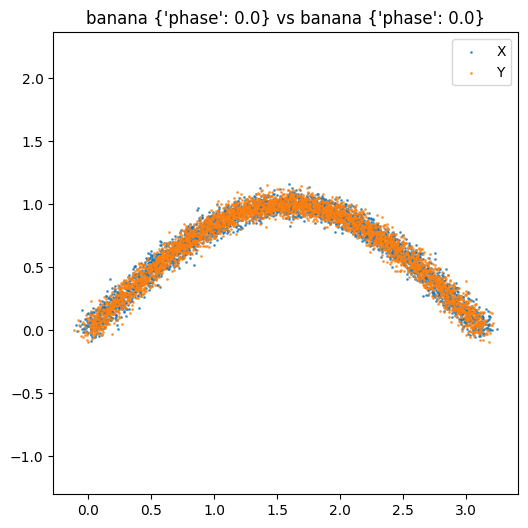

c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:388: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)


(banana, {'phase': 0.0}) vs (banana, {'phase': 0.0})
   SlicedWasserstein-PCA:   0.005789 (time: 0.03s)
   Gromov-Wasserstein:      0.015640940288746453 (time: 36.58s)
   Standard OT:             0.11896112458195555 (time: 1.82s)
   Procrustes OT:           0.11814169420683274 (time: 5.51s)
   --- Diffusion grid (assignment SlicedWasserstein) ---
      k= 10, t= 0: 0.008954, 3.636s
      k= 10, t= 1: 0.002459, 3.527s
      k= 10, t=10: 0.002301, 3.690s
   --- Standard Sliced Wasserstein by n_proj ---
      n_proj= 100: 0.006075, 0.026s
      n_proj=1000: 0.005958, 0.204s
      n_proj=10000: 0.005947, 2.246s



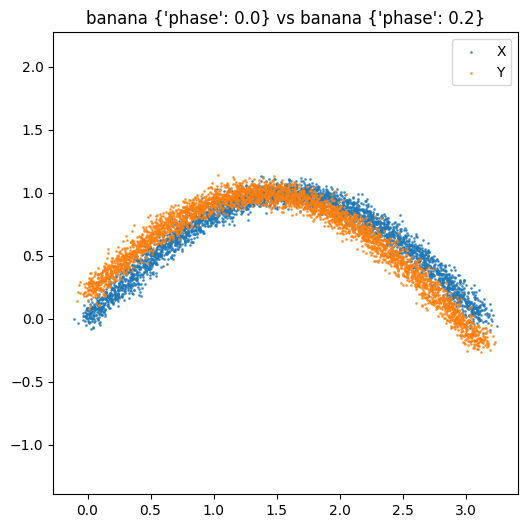

KeyboardInterrupt: 

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from scipy.linalg import orthogonal_procrustes
from scipy.sparse.linalg import eigsh
from sklearn import datasets
import itertools
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
from sklearn.manifold import SpectralEmbedding


try:
    import ot  # POT: Python Optimal Transport
    has_pot = True
except ImportError:
    print("python-ot (POT) not found, Gromov-Wasserstein/OT comparison disabled")
    has_pot = False

######################
# Embedding Functions #
######################


def spectral_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    k = k if k is not None else min(n - 1, Xc.shape[1])
    se = SpectralEmbedding(n_components=k, affinity='rbf')
    #se = SpectralEmbedding(n_components=k, affinity='nearest_neighbors', n_neighbors=min(10, n-1))
    return se.fit_transform(Xc)

def pca_embedding(X, k=None):
    Xc = X - X.mean(axis=0)
    pca = PCA(n_components=k if k else X.shape[1])
    pca.fit(Xc)
    return pca.transform(Xc)  # returns n x k array, like diffusion_embedding

def pca_embedding_with_eigvals_and_evecs(X, k=None):
    Xc = X - X.mean(axis=0)
    k = k if k else X.shape[1]
    pca = PCA(n_components=k)
    pca.fit(Xc)
    AX = pca.transform(Xc)
    eigvals = pca.explained_variance_
    evecs = pca.components_.T  # d x k
    return AX, eigvals, evecs

# think more about t and symmetric normalization
def diffusion_embedding(X, k=5, epsilon=None, t=1):
    Xc = X - X.mean(axis=0)
    n = Xc.shape[0]
    D_sq = cdist(Xc, Xc, 'sqeuclidean')
    if epsilon is None:
        epsilon = np.median(D_sq)
    K = np.exp(-D_sq / epsilon)
    d = np.sum(K, axis=1)
    D_inv_sqrt = np.diag(1.0 / np.sqrt(d))
    P_tilde = D_inv_sqrt @ K @ D_inv_sqrt

    # --- Choose eigensolver automatically ---
    # Full eigendecomposition if k >= n-1
    if k >= n - 1:
        vals, vecs = eigh(P_tilde)
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        # Remove the trivial eigenvector (usually the top one)
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]
    else:
        # Partial: only top k+1
        vals, vecs = eigsh(P_tilde, k=k+1, which='LM')
        order = np.argsort(vals)[::-1]
        vals = vals[order]
        vecs = vecs[:, order]
        lambdas = vals[1:k+1]
        phis = vecs[:, 1:k+1]

    embedding_matrix = phis * (lambdas ** t)
    return embedding_matrix


###################################
# Sliced Wasserstein Assignment   #
###################################

def get_sorted_columns(A):
    # A: n x k array
    # Returns: list of length k, each is sorted 1D array of size n
    return [np.sort(A[:, i]) for i in range(A.shape[1])]

# write more general 1D Wasserstein distance
def compute_1d_wasserstein_sorted(u_sorted, v_sorted): # we don't need to pass in sorted arrays, we can change this later
    n, m = len(u_sorted), len(v_sorted)
    a = np.ones(n) / n
    b = np.ones(m) / m
    return (ot.lp.emd2_1d(u_sorted, v_sorted, a, b)) # W2^2

def assignment_sliced_wasserstein(X, Y, AX, BY, eigvals_X=None, eigvals_Y=None, eigvecs_X=None, eigvecs_Y=None, print_pairings=False):
    k = AX.shape[1]
    # Precompute and cache sorted columns
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            # positive‐sign cost (both arrays already ascending)
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            # negative‐sign cost: reverse the sorted array before negating
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C[i, j] = min(d_pos, d_neg)
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()

    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
        print("\nRISWIE Axis Pairings:")
        for idx in range(len(row_ind)):
            i, j = row_ind[idx], col_ind[idx]
            print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                  f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}, "
                  f"contribution={C[i, j]:.6f}")
    return np.sqrt((1 / k) * total_cost)
 # to hopefully be a pseudometric - regardless, matching units


def assignment_weighted_during(X, Y, AX, BY, eigvals_X, eigvals_Y, eigvecs_X=None, eigvecs_Y=None, weight_type='geometric', print_pairings=False):
    k = AX.shape[1]
    # Normalize eigenvalues to sum to 1 if desired, or use raw eigvals for absolute weighting
    #eigvals_X = eigvals_X / eigvals_X.sum()
    #eigvals_Y = eigvals_Y / eigvals_Y.sum()
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            cost = min(d_pos, d_neg)
            if weight_type == 'geometric':
                w = np.sqrt(eigvals_X[i] * eigvals_Y[j]) # this pairs low variance axes with high variance axes
                #w = np.exp(-np.sqrt(eigvals_X[i] * eigvals_Y[j])) # maybe this will not do that
            elif weight_type == 'arithmetic':
                w = 0.5 * (eigvals_X[i] + eigvals_Y[j])
            else:
                raise ValueError("weight_type must be 'geometric' or 'arithmetic'")
            C[i, j] = w * cost
    row_ind, col_ind = linear_sum_assignment(C)
    total_cost = C[row_ind, col_ind].sum()
    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
        print("\nRISWIE-Z (Weighted-During) Axis Pairings:")
        for idx in range(len(row_ind)):
            i, j = row_ind[idx], col_ind[idx]
            print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                  f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}, "
                  f"contribution={C[i, j]:.6f}")
    return np.sqrt(total_cost / k)

def assignment_weighted_after(X, Y, AX, BY, eigvals_X, eigvals_Y, eigvecs_X=None, eigvecs_Y=None, weight_type='geometric', print_pairings=False):
    k = AX.shape[1]
    # Do NOT normalize eigenvalues beforehand
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C[i, j] = min(d_pos, d_neg)
    row_ind, col_ind = linear_sum_assignment(C)
    costs = C[row_ind, col_ind]
    # Compute geometric mean weights for assigned pairs (using raw eigvals)
    if weight_type == 'geometric':
        weights = np.sqrt(eigvals_X[row_ind] * eigvals_Y[col_ind])
    elif weight_type == 'arithmetic':
        weights = 0.5 * (eigvals_X[row_ind] + eigvals_Y[col_ind])
    else:
        raise ValueError("weight_type must be 'geometric' or 'arithmetic'")
    weights_sum = weights.sum()
    # Normalize weights to sum to 1
    weights = weights / weights_sum if weights_sum > 0 else np.ones_like(weights)/k
    total_cost = (weights * costs).sum()
    if print_pairings and eigvals_X is not None and eigvecs_X is not None and eigvals_Y is not None and eigvecs_Y is not None:
            print("\nRISWIE-J (Weighted-After) Axis Pairings:")
            for idx in range(len(row_ind)):
                i, j = row_ind[idx], col_ind[idx]
                cost = costs[idx]
                weight = weights[idx]
                contribution = weight * cost
                print(f"X axis {i}: eval={eigvals_X[i]:.3g}, evec={eigvecs_X[:,i]}   <--->   "
                    f"Y axis {j}: eval={eigvals_Y[j]:.3g}, evec={eigvecs_Y[:,j]}")
                print(f"    W2={cost:.6f} | weight={weight:.6f} | weighted contribution={contribution:.6f}")
    return np.sqrt(total_cost)

def softmin_sign(C_pos, C_neg, beta=10.0):
    # Soft-min over sign, shape (k, k)
    w = 1.0 / (1.0 + np.exp(beta * (C_pos - C_neg)))
    return w * C_pos + (1 - w) * C_neg

def assignment_sliced_wasserstein_soft_sinkhorn(X, Y, AX, BY, epsilon=0.08, beta=5.0, n_iter=50000):
    """
    Differentiable (soft) assignment sliced Wasserstein using POT Sinkhorn.
    """
    k = AX.shape[1]
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C_pos = np.zeros((k, k))
    C_neg = np.zeros((k, k))
    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C_pos[i, j] = d_pos
            C_neg[i, j] = d_neg
    # Soft sign selection
    C_soft = softmin_sign(C_pos, C_neg, beta=beta)

    # Uniform marginals
    a = np.ones(k) / k
    b = np.ones(k) / k

    # Use POT's Sinkhorn algorithm
    P = ot.sinkhorn(a, b, C_soft, reg=epsilon, numItermax=n_iter)
    total_cost = np.sum(P * C_soft)
    return np.sqrt(total_cost / k)

def assignment_sinkhorn_weighted(X, Y, AX, BY, eigvals_X, eigvals_Y, epsilon=0.08, beta=5.0, n_iter=50000):
    """
    Soft assignment weighted RISWIE (Sinkhorn):
      - Uses geometric mean weights W_ij = sqrt(eigval_X[i] * eigval_Y[j])
      - Applies weights after soft Sinkhorn assignment
      - Normalizes by the sum of W * P
    """
    k = AX.shape[1]
    AX_sorted = get_sorted_columns(AX)
    BY_sorted = get_sorted_columns(BY)
    C_pos = np.zeros((k, k))
    C_neg = np.zeros((k, k))

    for i in range(k):
        a_sorted = AX_sorted[i]
        for j in range(k):
            b_sorted = BY_sorted[j]
            d_pos = compute_1d_wasserstein_sorted(a_sorted, b_sorted)
            b_neg_sorted = -b_sorted[::-1]
            d_neg = compute_1d_wasserstein_sorted(a_sorted, b_neg_sorted)
            C_pos[i, j] = d_pos
            C_neg[i, j] = d_neg

    # Soft sign selection
    C_soft = softmin_sign(C_pos, C_neg, beta=beta)

    # Uniform marginals
    a = np.ones(k) / k
    b = np.ones(k) / k

    # Sinkhorn assignment
    P = ot.sinkhorn(a, b, C_soft, reg=epsilon, numItermax=n_iter)  # shape (k, k)

    # Geometric weights (not normalized yet)
    W = np.sqrt(np.outer(eigvals_X, eigvals_Y))  # shape (k, k)

    # Compute weighted cost and normalization
    weighted_cost = np.sum(W * P * C_soft)
    normalization = np.sum(W * P)

    D = np.sqrt(weighted_cost / normalization)
    return D


###

##############################
# Baselines: GW and OT and ...#
##############################

def gromov_wasserstein(X, Y):
    if not has_pot:
        return np.nan
    C1 = cdist(X, X)  # pairwise distance matrix for X
    C2 = cdist(Y, Y)  # pairwise distance matrix for Y
    # we assume uniform distributions for both sets
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    # GW returns the cost directly (not the coupling)
    gw_cost = ot.gromov.gromov_wasserstein2(C1, C2, p, q, 'square_loss')
    return np.sqrt(gw_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent


def standard_ot(X, Y):
    if X.shape[1] != Y.shape[1]: # need to live in same dimensional space
        raise ValueError(f"OT: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    # same deal as GW
    C = cdist(X, Y)
    p = np.ones(len(X)) / len(X)
    q = np.ones(len(Y)) / len(Y)
    T = ot.emd(p, q, C, numItermax=10000000)
    ot_cost = (C * T).sum()
    return np.sqrt(ot_cost) # we need to square root because assignment_sliced_wasserstein returns sqrt of cost and we want to be consistent

def orthogonal_procrustes_matching(X, Y, max_iter=10000, tol=1e-6, verbose=False):
    """
    Find the best orthogonal R (no scaling) and permutation π so that Xc ≈ (Yc @ R)[π].
    Returns the sum of squared distances under that R + π.
    """
    # 1) center both clouds
    Xc = X - X.mean(axis=0)
    Yc = Y - Y.mean(axis=0)
    n, d = Xc.shape

    # 2) start with the identity matching
    π = np.arange(n)
    cost_prev = np.inf

    for it in range(max_iter):
        # ─── Step 1: find the orthogonal rotation R (no scale) that best aligns Yc[π] → Xc ───
        R, _ = orthogonal_procrustes(Yc[π], Xc)
        Yc_rot = Yc @ R   # *** drop any scale ***

        # ─── Step 2: re‐compute the one‐to‐one assignment under the new rotation ───
        C = cdist(Xc, Yc_rot, metric='sqeuclidean')
        row_ind, col_ind = linear_sum_assignment(C)
        cost = C[row_ind, col_ind].sum()

        if verbose:
            print(f"Iter {it}: cost = {cost:.8f}")

        # check convergence
        if abs(cost - cost_prev) < tol:
            break

        cost_prev = cost
        π = col_ind

    # ─── Final transform (pure rotation + centroid shift) ───
    R, _ = orthogonal_procrustes(Yc[π], Xc)
    Yc_aligned = Yc @ R
    # add back X’s centroid
    Y_aligned = Yc_aligned + X.mean(axis=0)

    return cost, (Y_aligned, R, π)


def procrustes_ot(X, Y):
    if X.shape != Y.shape:
        raise ValueError(f"Procrustes: Shape mismatch {X.shape} vs {Y.shape}")
    cost, (Y_aligned, R, pi) = orthogonal_procrustes_matching(X, Y)
    # Now you can compare X and Y_aligned, or run OT/GW/etc.
    # For vanilla OT cost:
    return standard_ot(X, Y_aligned)

def sliced_wasserstein(X, Y, n_proj=100, p=2, seed=None):
    """
    Standard Sliced Wasserstein (squared Wp, default W2):
      - Projects onto random unit vectors
      - Computes 1D Wasserstein between projections
      - Returns the mean distance across all projections (root if p=2)
    """
    if X.shape[1] != Y.shape[1]:
        raise ValueError(f"SW: Feature dimension mismatch: {X.shape[1]} vs {Y.shape[1]}")
    rng = np.random.default_rng(seed)
    n, d = X.shape
    m = Y.shape[0]
    dists = []
    for _ in range(n_proj):
        v = rng.normal(size=d)
        v /= np.linalg.norm(v)  # unit vector

        # Project onto v
        X_proj = np.dot(X, v)
        Y_proj = np.dot(Y, v)

        # Sort and compute 1D Wasserstein-p distance
        X_proj_sorted = np.sort(X_proj)
        Y_proj_sorted = np.sort(Y_proj)
        # Need equal sizes for empirical distributions: subsample or interpolate if needed
        n_used = min(len(X_proj_sorted), len(Y_proj_sorted))
        Xs = X_proj_sorted[:n_used]
        Ys = Y_proj_sorted[:n_used]
        dist = np.mean(np.abs(Xs - Ys) ** p)
        dists.append(dist)

    return np.mean(dists)**(1/p)




########################
# Synthetic Datasets   #
########################

def generate_dataset(kind, n=100, d=2, mean=None, cov=None, angle=None, phase=None):
    if kind == 'normal':
        m = mean if mean is not None else np.zeros(d)
        c = cov if cov is not None else np.eye(d)
        X = np.random.multivariate_normal(m, c, n)
        return X
    elif kind == 'banana':
        t = np.linspace(0, np.pi, n)
        phi = phase if phase is not None else 0.0
        X = np.vstack([t, np.sin(t + phi)]).T + 0.05 * np.random.randn(n, 2)
        return X
    elif kind == 'cylinder':
        theta = np.random.uniform(0, 2*np.pi, n)
        z = np.random.uniform(-1, 1, n)
        ang = angle if angle is not None else 0.0
        X = np.vstack([np.cos(theta + ang), np.sin(theta + ang), z]).T
        return X
    elif kind == 'swissroll':
        X, _ = datasets.make_swiss_roll(n)
        return X[:, :d]
    else:
        raise ValueError('Unknown dataset kind')

def plot_pair(X, Y, title=None, savepath=None):
    plt.figure(figsize=(6,6))
    plt.scatter(X[:,0], X[:,1], s=1, label='X', alpha=0.7)
    plt.scatter(Y[:,0], Y[:,1], s=1, label='Y', alpha=0.7)
    plt.axis('equal')
    plt.legend()
    if title:
        plt.title(title)
    if savepath:
        plt.savefig(savepath)
        plt.close()
    else:
        plt.show()

##########################################################
# Dataset parameterizations to try (expand as desired)   #
##########################################################

DATASET_PARAMS = {
    'banana': [
        dict(phase=0.0),
        dict(phase=0.2),
        dict(phase=1.0),
    ],
    'cylinder': [
        dict(angle=0.0),
        dict(angle=0.2),
        dict(angle=np.pi/2),
    ],
    'normal': [
        dict(mean=np.zeros(2)),
        dict(mean=np.ones(2)),
        dict(mean=np.array([2.0, -2.0])),
        dict(mean=np.zeros(2), cov=np.diag([1, 4])),
        dict(mean=np.zeros(2), cov=2*np.eye(2)),
        dict(mean=np.zeros(2), angle=np.pi/4),  # for rotation
    ],
    'swissroll': [
        dict(),  # no params
    ]
}

########################################
# Cartesian Product of Tests Framework #
########################################

def test_diffusion_grid(X, Y, k_values, t_values, distance_fn):
    results = {}
    for k in k_values:
        for t in t_values:
            try:
                t0 = time.time()
                AX = diffusion_embedding(X, k=k, t=t)
                BY = diffusion_embedding(Y, k=k, t=t)
                # Optionally rescale to match variance for fair distance comparison
                # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
                scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
                AX *= scale
                BY *= scale
                dist = distance_fn(X, Y, AX, BY)
                t1 = time.time()
                results[(k, t)] = (dist, t1 - t0)
            except Exception as e:
                results[(k, t)] = (str(e), None)  # capture any errors
    return results

def test_sliced_wasserstein_proj(X, Y, n_proj_values, seed=None):
    results = {}
    for n_proj in n_proj_values:
        try:
            t0 = time.time()
            dist = sliced_wasserstein(X, Y, n_proj=n_proj, p=2, seed=seed)
            t1 = time.time()
            results[n_proj] = (dist, t1 - t0)
        except Exception as e:
            results[n_proj] = (str(e), None)
    return results

def test_framework():
    dataset_types = list(DATASET_PARAMS.keys())
    configs = []
    for dtype in dataset_types:
        for params in DATASET_PARAMS[dtype]:
            configs.append((dtype, params))

    # Grid parameters
    k_values = [10]
    t_values = [0, 1, 10]
    n_proj_values = [100, 1000, 10000]

    rows = []
    print("Pairwise tests (cartesian product):\n")
    for (dtype1, p1), (dtype2, p2) in itertools.product(configs, configs):
        n = 3500
        X = generate_dataset(dtype1, n=n, d=2, **p1)
        Y = generate_dataset(dtype2, n=n, d=2, **p2)
        plot_pair(X, Y, title=f'{dtype1} {p1} vs {dtype2} {p2}', savepath=None)
        k = min(X.shape[1], Y.shape[1])

        # PCA embedding baseline
        t0 = time.time()
        AX = pca_embedding(X, k)
        BY = pca_embedding(Y, k)
        # Scale PCA embeddings to match input variance - heuristic
        # This can be shown to just scale the distance by a constant factor scale^1 (scale^2 is sqrted), so it is monotonic and solely for fair comparison
        scale = np.sqrt(np.trace(np.cov(X.T)) / np.trace(np.cov(AX.T)))
        AX *= scale
        BY *= scale
        d_pca = assignment_sliced_wasserstein(X, Y, AX, BY)
        t1 = time.time()
        pca_time = t1 - t0

        # Diffusion embedding grid (k, t)
        diffusion_results = test_diffusion_grid(
            X, Y, k_values=k_values, t_values=t_values,
            distance_fn=assignment_sliced_wasserstein
        )

        # Sliced Wasserstein with varying n_proj (standard)
        sw_proj_results = test_sliced_wasserstein_proj(
            X, Y, n_proj_values=n_proj_values, seed=42
        )

        # GW, OT, Procrustes
        t0 = time.time()
        d_gw = gromov_wasserstein(X, Y)
        t1 = time.time()
        gw_time = t1 - t0

        try:
            t0 = time.time()
            d_ot = standard_ot(X, Y)
            t1 = time.time()
            ot_time = t1 - t0
        except ValueError as e:
            d_ot = str(e)
            ot_time = None

        try:
            t0 = time.time()
            d_proc = procrustes_ot(X, Y)
            t1 = time.time()
            procrustes_time = t1 - t0
        except ValueError as e:
            d_proc = str(e)
            procrustes_time = None

        print(f'({dtype1}, {p1}) vs ({dtype2}, {p2})')
        print(f'   SlicedWasserstein-PCA:   {d_pca:.4g} (time: {pca_time:.2f}s)' if pca_time is not None else '   SlicedWasserstein-PCA:   Error')
        print(f'   Gromov-Wasserstein:      {d_gw} (time: {gw_time:.2f}s)' if gw_time is not None else '   Gromov-Wasserstein:      Error')
        print(f'   Standard OT:             {d_ot} (time: {ot_time:.2f}s)' if ot_time is not None else '   Standard OT:             Error')
        print(f'   Procrustes OT:           {d_proc} (time: {procrustes_time:.2f}s)' if procrustes_time is not None else '   Procrustes OT:           Error')
        print('   --- Diffusion grid (assignment SlicedWasserstein) ---')
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            print(f'      k={kk:3d}, t={tt:2d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      k={kk:3d}, t={tt:2d}: Error')
        print('   --- Standard Sliced Wasserstein by n_proj ---')
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            print(f'      n_proj={n_proj:4d}: {dist:.4g}, {t_elapsed:.3f}s' if t_elapsed is not None else f'      n_proj={n_proj:4d}: Error')
        print()
        row = {
            'A_type': dtype1,
            'A_params': str(p1),
            'B_type': dtype2,
            'B_params': str(p2),
            'sliced_pca': d_pca,
            'sliced_pca_time': pca_time,
            'gromov_wasserstein': d_gw,
            'gromov_wasserstein_time': gw_time,
            'standard_ot': d_ot,
            'standard_ot_time': ot_time,
            'procrustes_ot': d_proc,
            'procrustes_ot_time': procrustes_time,
        }
        # Add diffusion results
        for (kk, tt), (dist, t_elapsed) in sorted(diffusion_results.items()):
            row[f'diffusion_k{kk}_t{tt}'] = dist
            row[f'diffusion_k{kk}_t{tt}_time'] = t_elapsed
        # Add SW projections
        for n_proj, (dist, t_elapsed) in sorted(sw_proj_results.items()):
            row[f'sw_proj{n_proj}'] = dist
            row[f'sw_proj{n_proj}_time'] = t_elapsed
        rows.append(row)
    df = pd.DataFrame(rows)
    df.to_csv('all_scores_per_pair.csv', index=False)

if __name__ == '__main__':
    test_framework()

pairwise distances:   0%|          | 0/90 [00:00<?, ?it/s]c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)
c:\Users\zakkh\AppData\Local\Programs\Python\Python312\Lib\site-packages\ot\lp\__init__.py:630: UserWarning: numItermax reached be

Accuracy OT:    0.027160493827160494
Accuracy SW:    0.37530864197530867
Accuracy RIS:   0.3012345679012346
Accuracy J:   0.3802469135802469


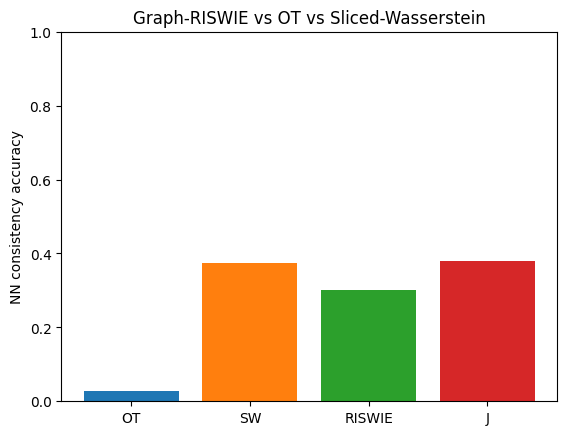

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–Embedding Robustness Experiment: OT vs. Sliced-Wasserstein vs. RISWIE
==========================================================================

Ten datasets := 5 clusters of English words  +  5 clusters of Spanish words
For each dataset build 10 graphs (knn, radius, epsilon variants)
Compute spectral embeddings (d = 30)                   -> 100 embeddings
Compute 100×100 pairwise distances under three metrics
  • Standard OT
  • Sliced Wasserstein (1000 random directions)
  • RISWIE
For each graph, find its 9 nearest neighbours (excluding self) under each metric
and compute the fraction that share the same dataset label.
Plot a bar chart of the three accuracies.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import ot  # POT library

# ---------------------------------------------------------------------
# I/O helpers ----------------------------------------------------------

def read_vec(path, dtype="float32"):
    with open(path, "r", encoding="utf-8") as f:
        n, dim = map(int, f.readline().split())
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat

# ---------------------------------------------------------------------
# Graph constructions -------------------------------------------------

def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False)
    return 0.5*(A + A.T)

def radius_graph(X, radius):
    D = squareform(pdist(X))
    A = (D <= radius).astype(float)
    np.fill_diagonal(A, 0)
    return csr_matrix(A)

def epsilon_graph(X, epsilon):
    D = squareform(pdist(X))
    W = np.exp(-D**2/(2*epsilon**2))
    W[D > 3*epsilon] = 0
    np.fill_diagonal(W, 0)
    return csr_matrix(W)

# ---------------------------------------------------------------------
# Embedding -----------------------------------------------------------

def spectral_embed_graph(A, dim=30):
    L = csgraph.laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=dim+1, which="SM", tol=1e-3, maxiter=50000)
    idx = np.argsort(vals)
    return vecs[:, idx[1:dim+1]]

# ---------------------------------------------------------------------
# Distance metrics ----------------------------------------------------

def ot_distance(X, Y):
    C = cdist(X, Y, 'sqeuclidean')
    n, m = X.shape[0], Y.shape[0]
    p, q = np.ones(n)/n, np.ones(m)/m
    return np.sqrt(ot.emd2(p, q, C))

def sliced_wasserstein_distance(X, Y, num_dirs=200):
    d = X.shape[1]
    sw2 = 0.0
    for _ in range(num_dirs):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        sw2 += _w2_1d(X.dot(u), Y.dot(u))
    return np.sqrt(sw2/num_dirs)

# RISWIE as before
def _w2_1d(u, v):
    n, m = len(u), len(v)
    return ot.lp.emd2_1d(np.sort(u), np.sort(v), np.ones(n)/n, np.ones(m)/m)

def riswie_distance(X, Y):
    d = X.shape[1]
    C = np.zeros((d, d))
    for i in range(d):
        ux = np.sort(X[:,i])
        for j in range(d):
            vy = np.sort(Y[:,j])
            pos = _w2_1d(ux, vy)
            neg = _w2_1d(ux, -vy[::-1])
            C[i,j] = min(pos, neg)
    ri, ci = linear_sum_assignment(C)
    return np.sqrt(C[ri,ci].mean())

# ---------------------------------------------------------------------
# Pipeline ------------------------------------------------------------

def build_graphs_and_embeddings(cloud):
    # pick parameters based on cloud
    D = pdist(cloud); med = np.median(D)
    pcts = np.percentile(D, [10,20,30])
    recipes = [
        ("knn", 2*int(np.log(len(cloud))) + k)
        for k in (-2,0,2)
    ] + [
        ("r", p) for p in pcts
    ] + [
        ("eps", med*f) for f in (0.8,1.0,1.2)
    ]
    graphs, embs = [], []
    for typ, param in tqdm(recipes, desc="  building graphs"):
        if typ=="knn":
            A = knn_graph(cloud, param)
        elif typ=="r":
            A = radius_graph(cloud, param)
        else:
            A = epsilon_graph(cloud, param)
        graphs.append(A)
        embs.append(spectral_embed_graph(A, dim=24))
    return graphs, embs

def nearest_neighbor_accuracy(dist_mat, tags):
    n = len(tags)
    correct = 0
    for i in range(n):
        nbrs = np.argsort(dist_mat[i])[1:10]
        correct += sum(tags[j]==tags[i] for j in nbrs)
    return correct/(n*9)

def main():
    # 1) load word vectors & cluster
    en_w, X_en = read_vec("data/wiki.en.10k.vec")
    es_w, X_es = read_vec("data/wiki.es.10k.vec")
    km_en = KMeans(5, random_state=0).fit(X_en)
    km_es = KMeans(5, random_state=0).fit(X_es)
    clusters = []
    for cid in range(5):
        clusters.append((f"EN{cid}", X_en[km_en.labels_==cid]))
        clusters.append((f"ES{cid}", X_es[km_es.labels_==cid]))

    # 2) build all embeddings
    all_embs, all_tags = [], []
    for tag, cloud in enumerate(clusters):
        name, pts = cloud
        _, embs = build_graphs_and_embeddings(pts)
        all_embs.extend(embs)
        all_tags.extend([tag]*len(embs))

    N = len(all_embs)
    # 3) compute 3 distance matrices
    D_ot  = np.zeros((N,N))
    D_sw  = np.zeros((N,N))
    D_ris = np.zeros((N,N))
    D_j = np.zeros((N,N))  

    for i in tqdm(range(N), desc="pairwise distances"):
        Ei = all_embs[i]
        for j in range(i+1, N):
            Ej = all_embs[j]
            D_ot[i,j]  = D_ot[j,i]  = ot_distance(Ei, Ej)
            D_sw[i,j]  = D_sw[j,i]  = sliced_wasserstein_distance(Ei, Ej, num_dirs=200)
            D_ris[i,j] = D_ris[j,i] = riswie_distance(Ei, Ej)
            AX, eigvals_X, eigvecs_X = pca_embedding_with_eigvals_and_evecs(Ei, k=16)
            BY, eigvals_Y, eigvecs_Y = pca_embedding_with_eigvals_and_evecs(Ej, k=16)

            # 2) call the "after" weighted assignment
            d_w = assignment_weighted_after(
                Ei, Ej,               # original point clouds (only used if you print pairings)
                AX, BY,               # their PCA embeddings
                eigvals_X, eigvals_Y,
                eigvecs_X, eigvecs_Y,
                weight_type='geometric',   # or 'arithmetic'
                print_pairings=False
            )

            D_j[i,j] = D_j[j,i] = d_w



    # 4) compute accuracies
    acc_ot  = nearest_neighbor_accuracy(D_ot,  all_tags)
    acc_sw  = nearest_neighbor_accuracy(D_sw,  all_tags)
    acc_ris = nearest_neighbor_accuracy(D_ris, all_tags)
    acc_j = nearest_neighbor_accuracy(D_j, all_tags)
    print("Accuracy OT:   ", acc_ot)
    print("Accuracy SW:   ", acc_sw)
    print("Accuracy RIS:  ", acc_ris)
    print("Accuracy J:  ", acc_j)

    # 5) plot
    metrics = ["OT", "SW", "RISWIE", "J"]
    #metrics = ["SW", "RISWIE"]
    accs    = [acc_ot, acc_sw, acc_ris, acc_j]
    #accs    = [acc_sw, acc_ris]
    plt.bar(metrics, accs, color=['C0','C1','C2', 'C3'])
    plt.ylim(0,1)
    plt.ylabel("NN consistency accuracy")
    plt.title("Graph-RISWIE vs OT vs Sliced-Wasserstein")
    plt.show()

if __name__=="__main__":
    main()


pairwise distances: 100%|██████████| 90/90 [7:05:09<00:00, 283.44s/it]   

Accuracy SW:    0.4703703703703704
Accuracy RIS:   0.34814814814814815
Accuracy J:   0.4691358024691358


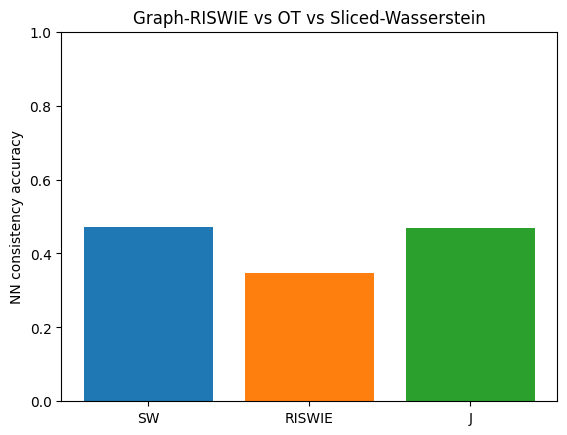

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–Embedding Robustness Experiment: OT vs. Sliced-Wasserstein vs. RISWIE
==========================================================================

Ten datasets := 5 clusters of English words  +  5 clusters of Spanish words
For each dataset build 10 graphs (knn, radius, epsilon variants)
Compute spectral embeddings (d = 30)                   -> 100 embeddings
Compute 100×100 pairwise distances under three metrics
  • Standard OT
  • Sliced Wasserstein (1000 random directions)
  • RISWIE
For each graph, find its 9 nearest neighbours (excluding self) under each metric
and compute the fraction that share the same dataset label.
Plot a bar chart of the three accuracies.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import ot  # POT library

# ---------------------------------------------------------------------
# I/O helpers ----------------------------------------------------------

def read_vec(path, dtype="float32"):
    with open(path, "r", encoding="utf-8") as f:
        n, dim = map(int, f.readline().split())
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat

# ---------------------------------------------------------------------
# Graph constructions -------------------------------------------------

def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False)
    return 0.5*(A + A.T)

def radius_graph(X, radius):
    D = squareform(pdist(X))
    A = (D <= radius).astype(float)
    np.fill_diagonal(A, 0)
    return csr_matrix(A)

def epsilon_graph(X, epsilon):
    D = squareform(pdist(X))
    W = np.exp(-D**2/(2*epsilon**2))
    W[D > 3*epsilon] = 0
    np.fill_diagonal(W, 0)
    return csr_matrix(W)

# ---------------------------------------------------------------------
# Embedding -----------------------------------------------------------

def spectral_embed_graph(A, dim=30):
    L = csgraph.laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=dim+1, which="SM", tol=1e-3, maxiter=50000)
    idx = np.argsort(vals)
    return vecs[:, idx[1:dim+1]]

# ---------------------------------------------------------------------
# Distance metrics ----------------------------------------------------

def ot_distance(X, Y):
    C = cdist(X, Y, 'sqeuclidean')
    n, m = X.shape[0], Y.shape[0]
    p, q = np.ones(n)/n, np.ones(m)/m
    return np.sqrt(ot.emd2(p, q, C))

def sliced_wasserstein_distance(X, Y, num_dirs=200):
    d = X.shape[1]
    sw2 = 0.0
    for _ in range(num_dirs):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        sw2 += _w2_1d(X.dot(u), Y.dot(u))
    return np.sqrt(sw2/num_dirs)

# RISWIE as before
def _w2_1d(u, v):
    n, m = len(u), len(v)
    return ot.lp.emd2_1d(np.sort(u), np.sort(v), np.ones(n)/n, np.ones(m)/m)

def riswie_distance(X, Y):
    d = X.shape[1]
    C = np.zeros((d, d))
    for i in range(d):
        ux = np.sort(X[:,i])
        for j in range(d):
            vy = np.sort(Y[:,j])
            pos = _w2_1d(ux, vy)
            neg = _w2_1d(ux, -vy[::-1])
            C[i,j] = min(pos, neg)
    ri, ci = linear_sum_assignment(C)
    return np.sqrt(C[ri,ci].mean())

# ---------------------------------------------------------------------
# Pipeline ------------------------------------------------------------

def build_graphs_and_embeddings(cloud):
    # pick parameters based on cloud
    D = pdist(cloud); med = np.median(D)
    pcts = np.percentile(D, [10,20,30])
    recipes = [
        ("knn", 2*int(np.log(len(cloud))) + k)
        for k in (-2,0,2)
    ] + [
        ("r", p) for p in pcts
    ] + [
        ("eps", med*f) for f in (0.8,1.0,1.2)
    ]
    graphs, embs = [], []
    for typ, param in tqdm(recipes, desc="  building graphs"):
        if typ=="knn":
            A = knn_graph(cloud, param)
        elif typ=="r":
            A = radius_graph(cloud, param)
        else:
            A = epsilon_graph(cloud, param)
        graphs.append(A)
        embs.append(spectral_embed_graph(A, dim=96))
    return graphs, embs

def nearest_neighbor_accuracy(dist_mat, tags):
    n = len(tags)
    correct = 0
    for i in range(n):
        nbrs = np.argsort(dist_mat[i])[1:10]
        correct += sum(tags[j]==tags[i] for j in nbrs)
    return correct/(n*9)

def main():
    # 1) load word vectors & cluster
    en_w, X_en = read_vec("data/wiki.en.10k.vec")
    es_w, X_es = read_vec("data/wiki.es.10k.vec")
    km_en = KMeans(5, random_state=0).fit(X_en)
    km_es = KMeans(5, random_state=0).fit(X_es)
    clusters = []
    for cid in range(5):
        clusters.append((f"EN{cid}", X_en[km_en.labels_==cid]))
        clusters.append((f"ES{cid}", X_es[km_es.labels_==cid]))

    # 2) build all embeddings
    all_embs, all_tags = [], []
    for tag, cloud in enumerate(clusters):
        name, pts = cloud
        _, embs = build_graphs_and_embeddings(pts)
        all_embs.extend(embs)
        all_tags.extend([tag]*len(embs))

    N = len(all_embs)
    # 3) compute 3 distance matrices
    D_ot  = np.zeros((N,N))
    D_sw  = np.zeros((N,N))
    D_ris = np.zeros((N,N))
    D_j = np.zeros((N,N))  

    for i in tqdm(range(N), desc="pairwise distances"):
        Ei = all_embs[i]
        for j in range(i+1, N):
            Ej = all_embs[j]
            #D_ot[i,j]  = D_ot[j,i]  = ot_distance(Ei, Ej)
            D_sw[i,j]  = D_sw[j,i]  = sliced_wasserstein_distance(Ei, Ej, num_dirs=92)
            D_ris[i,j] = D_ris[j,i] = riswie_distance(Ei, Ej)
            AX, eigvals_X, eigvecs_X = pca_embedding_with_eigvals_and_evecs(Ei, k=92)
            BY, eigvals_Y, eigvecs_Y = pca_embedding_with_eigvals_and_evecs(Ej, k=92)

            # 2) call the "after" weighted assignment
            d_w = assignment_weighted_after(
                Ei, Ej,               # original point clouds (only used if you print pairings)
                AX, BY,               # their PCA embeddings
                eigvals_X, eigvals_Y,
                eigvecs_X, eigvecs_Y,
                weight_type='geometric',   # or 'arithmetic'
                print_pairings=False
            )

            D_j[i,j] = D_j[j,i] = d_w



    # 4) compute accuracies
    acc_ot  = nearest_neighbor_accuracy(D_ot,  all_tags)
    acc_sw  = nearest_neighbor_accuracy(D_sw,  all_tags)
    acc_ris = nearest_neighbor_accuracy(D_ris, all_tags)
    acc_j = nearest_neighbor_accuracy(D_j, all_tags)
    #print("Accuracy OT:   ", acc_ot)
    print("Accuracy SW:   ", acc_sw)
    print("Accuracy RIS:  ", acc_ris)
    print("Accuracy J:  ", acc_j)

    # 5) plot
    metrics = ["SW", "RISWIE", "J"]
    #metrics = ["SW", "RISWIE"]
    accs    = [acc_sw, acc_ris, acc_j]
    #accs    = [acc_sw, acc_ris]
    plt.bar(metrics, accs, color=['C0','C1','C2'])
    plt.ylim(0,1)
    plt.ylabel("NN consistency accuracy")
    plt.title("Graph-RISWIE vs OT vs Sliced-Wasserstein")
    plt.show()

if __name__=="__main__":
    main()


In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Graph–Embedding Robustness Experiment: OT vs. Sliced-Wasserstein vs. RISWIE
==========================================================================

Ten datasets := 5 clusters of English words  +  5 clusters of Spanish words
For each dataset build 10 graphs (knn, radius, epsilon variants)
Compute spectral embeddings (d = 30)                   -> 100 embeddings
Compute 100×100 pairwise distances under three metrics
  • Standard OT
  • Sliced Wasserstein (1000 random directions)
  • RISWIE
For each graph, find its 9 nearest neighbours (excluding self) under each metric
and compute the fraction that share the same dataset label.
Plot a bar chart of the three accuracies.
"""

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform, cdist
from scipy.sparse import csr_matrix, csgraph
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment
from sklearn.cluster import KMeans
from sklearn.neighbors import kneighbors_graph
from tqdm import tqdm
import ot  # POT library

# ---------------------------------------------------------------------
# I/O helpers ----------------------------------------------------------

def read_vec(path, dtype="float32"):
    with open(path, "r", encoding="utf-8") as f:
        n, dim = map(int, f.readline().split())
        words, mat = [], np.empty((n, dim), dtype=dtype)
        for i in range(n):
            w, vec = f.readline().split(" ", 1)
            words.append(w)
            mat[i] = np.fromstring(vec, sep=" ", dtype=dtype)
    return words, mat

# ---------------------------------------------------------------------
# Graph constructions -------------------------------------------------

def knn_graph(X, k):
    A = kneighbors_graph(X, n_neighbors=k, include_self=False)
    return 0.5*(A + A.T)

def radius_graph(X, radius):
    D = squareform(pdist(X))
    A = (D <= radius).astype(float)
    np.fill_diagonal(A, 0)
    return csr_matrix(A)

def epsilon_graph(X, epsilon):
    D = squareform(pdist(X))
    W = np.exp(-D**2/(2*epsilon**2))
    W[D > 3*epsilon] = 0
    np.fill_diagonal(W, 0)
    return csr_matrix(W)

# ---------------------------------------------------------------------
# Embedding -----------------------------------------------------------

def spectral_embed_graph(A, dim=30):
    L = csgraph.laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=dim+1, which="SM", tol=1e-3, maxiter=50000)
    idx = np.argsort(vals)
    return vecs[:, idx[1:dim+1]]

# ---------------------------------------------------------------------
# Distance metrics ----------------------------------------------------

def ot_distance(X, Y):
    C = cdist(X, Y, 'sqeuclidean')
    n, m = X.shape[0], Y.shape[0]
    p, q = np.ones(n)/n, np.ones(m)/m
    return np.sqrt(ot.emd2(p, q, C))

def sliced_wasserstein_distance(X, Y, num_dirs=200):
    d = X.shape[1]
    sw2 = 0.0
    for _ in range(num_dirs):
        u = np.random.randn(d)
        u /= np.linalg.norm(u)
        sw2 += _w2_1d(X.dot(u), Y.dot(u))
    return np.sqrt(sw2/num_dirs)

# RISWIE as before
def _w2_1d(u, v):
    n, m = len(u), len(v)
    return ot.lp.emd2_1d(np.sort(u), np.sort(v), np.ones(n)/n, np.ones(m)/m)

def riswie_distance(X, Y):
    d = X.shape[1]
    C = np.zeros((d, d))
    for i in range(d):
        ux = np.sort(X[:,i])
        for j in range(d):
            vy = np.sort(Y[:,j])
            pos = _w2_1d(ux, vy)
            neg = _w2_1d(ux, -vy[::-1])
            C[i,j] = min(pos, neg)
    ri, ci = linear_sum_assignment(C)
    return np.sqrt(C[ri,ci].mean())

# ---------------------------------------------------------------------
# Pipeline ------------------------------------------------------------

def build_graphs_and_embeddings(cloud):
    # pick parameters based on cloud
    D = pdist(cloud); med = np.median(D)
    pcts = np.percentile(D, [10,20,30])
    recipes = [
        ("knn", 2*int(np.log(len(cloud))) + k)
        for k in (-2,0,2)
    ] + [
        ("r", p) for p in pcts
    ] + [
        ("eps", med*f) for f in (0.8,1.0,1.2)
    ]
    graphs, embs = [], []
    for typ, param in tqdm(recipes, desc="  building graphs"):
        if typ=="knn":
            A = knn_graph(cloud, param)
        elif typ=="r":
            A = radius_graph(cloud, param)
        else:
            A = epsilon_graph(cloud, param)
        graphs.append(A)
        embs.append(spectral_embed_graph(A, dim=96))
    return graphs, embs

# def nearest_neighbor_accuracy(dist_mat, tags):
#     n = len(tags)
#     correct = 0
#     for i in range(n):
#         nbrs = np.argsort(dist_mat[i])[1:10]
#         correct += sum(tags[j]==tags[i] for j in nbrs)
#     return correct/(n*9)

def nearest_neighbor_accuracy(dist_mat, tags, 
                                       k=19, 
                                       decay='exponential', 
                                       param=1.0):
    """
    Weighted k-NN consistency:
      - For each point i, look at its k nearest neighbours (excluding itself).
      - Assign a weight w_r to the neighbour at rank r (0-based).
      - Sum up w_r whenever the neighbour has the same tag.
      - Normalize by the sum of all w_r across all points.

    Args:
      dist_mat: (n×n) pairwise distance matrix.
      tags:     length-n array of integer labels.
      k:        how many neighbours to consider per point.
      decay:    'exponential' or 'power' decay of weight with rank.
      param:    if decay='exponential', α in w_r = exp(−α·r);
                if decay='power', p in w_r = 1/(r+1)^p.

    Returns:
      Weighted accuracy ∈ [0,1].
    """
    n = len(tags)
    # build weight vector of length k
    if decay == 'exponential':
        α = param
        weights = np.exp(-α * np.arange(k))
    elif decay == 'power':
        p = param
        weights = 1.0 / ((np.arange(k) + 1) ** p)
    else:
        raise ValueError("decay must be 'exponential' or 'power'")
    
    total_correct = 0.0
    total_weight  = 0.0

    for i in range(n):
        # indices of the k nearest neighbours (skip self at rank 0)
        nbrs = np.argsort(dist_mat[i])[1:k+1]
        for r, j in enumerate(nbrs):
            w = weights[r]
            total_weight += w
            if tags[j] == tags[i]:
                total_correct += w

    return total_correct / total_weight

def main():
    # 1) load word vectors & cluster
    en_w, X_en = read_vec("data/wiki.en.10k.vec")
    es_w, X_es = read_vec("data/wiki.es.10k.vec")
    km_en = KMeans(10, random_state=0).fit(X_en)
    km_es = KMeans(10, random_state=0).fit(X_es)
    clusters = []
    for cid in range(10):
        clusters.append((f"EN{cid}", X_en[km_en.labels_==cid]))
        clusters.append((f"ES{cid}", X_es[km_es.labels_==cid]))

    # 2) build all embeddings
    all_embs, all_tags = [], []
    for tag, cloud in enumerate(clusters):
        name, pts = cloud
        _, embs = build_graphs_and_embeddings(pts)
        all_embs.extend(embs)
        all_tags.extend([tag]*len(embs))

    N = len(all_embs)
    # 3) compute 3 distance matrices
    D_ot  = np.zeros((N,N))
    D_sw  = np.zeros((N,N))
    D_ris = np.zeros((N,N))
    D_j = np.zeros((N,N))  

    for i in tqdm(range(N), desc="pairwise distances"):
        Ei = all_embs[i]
        for j in range(i+1, N):
            Ej = all_embs[j]
            D_ot[i,j]  = D_ot[j,i]  = ot_distance(Ei, Ej)
            D_sw[i,j]  = D_sw[j,i]  = sliced_wasserstein_distance(Ei, Ej, num_dirs=64)
            D_ris[i,j] = D_ris[j,i] = riswie_distance(Ei, Ej)
            AX, eigvals_X, eigvecs_X = pca_embedding_with_eigvals_and_evecs(Ei, k=62)
            BY, eigvals_Y, eigvecs_Y = pca_embedding_with_eigvals_and_evecs(Ej, k=62)

            # 2) call the "after" weighted assignment
            d_w = assignment_weighted_after(
                Ei, Ej,               # original point clouds (only used if you print pairings)
                AX, BY,               # their PCA embeddings
                eigvals_X, eigvals_Y,
                eigvecs_X, eigvecs_Y,
                weight_type='geometric',   # or 'arithmetic'
                print_pairings=False
            )

            D_j[i,j] = D_j[j,i] = d_w



    # 4) compute accuracies
    acc_ot  = nearest_neighbor_accuracy(D_ot,  all_tags)
    acc_sw  = nearest_neighbor_accuracy(D_sw,  all_tags)
    acc_ris = nearest_neighbor_accuracy(D_ris, all_tags)
    acc_j = nearest_neighbor_accuracy(D_j, all_tags)
    print("Accuracy OT:   ", acc_ot)
    print("Accuracy SW:   ", acc_sw)
    print("Accuracy RIS:  ", acc_ris)
    print("Accuracy J:  ", acc_j)

    # 5) plot
    metrics = ["OT", "SW", "RISWIE", "J"]
    #metrics = ["SW", "RISWIE"]
    accs    = [acc_ot, acc_sw, acc_ris, acc_j]
    #accs    = [acc_sw, acc_ris]
    plt.bar(metrics, accs, color=['C0','C1','C2', 'C3'])
    plt.ylim(0,1)
    plt.ylabel("NN consistency accuracy")
    plt.title("Graph-RISWIE vs OT vs Sliced-Wasserstein")
    plt.show()

if __name__=="__main__":
    main()


pairwise distances:   0%|          | 0/180 [06:59<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
SBM Parameter‐Recovery via Graph Distances
==========================================

We generate stochastic‐block‐model (SBM) graphs with two equal blocks of size 50,
varying (p_in, p_out) over a grid.  We then compute three graph‐distances:
  • RISWIE on the top‐m Laplacian eigenvectors
  • Gromov–Wasserstein on unweighted shortest‐path metrics
  • Standard OT on the same Laplacian embeddings

Finally, we compare each measured distance to the “true” parameter distance
in the (p_in, p_out) plane via Pearson correlation and a scatter plot.
"""

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import ot
from scipy.sparse.csgraph import shortest_path, laplacian
from scipy.sparse.linalg import eigsh
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from networkx import adjacency_matrix

# --- 1) generate SBM ---
def generate_sbm(n=100, pin=0.3, pout=0.05):
    sizes = [n//2, n - n//2]
    block_probs = [[pin, pout],
                   [pout, pin]]
    G = nx.stochastic_block_model(sizes, block_probs)
    return nx.adjacency_matrix(G)

# --- 2) Laplacian embedding for RISWIE / OT ---
def laplacian_embedding(A, m=10):
    L = laplacian(A, normed=True)
    vals, vecs = eigsh(L, k=m+1, which='SM', tol=1e-3, maxiter=20000)
    idx = np.argsort(vals)
    return vecs[:, idx[1:m+1]]

# --- 3) RISWIE distance on embeddings ---
def _w2_1d(u, v):
    a = np.ones(len(u))/len(u)
    b = np.ones(len(v))/len(v)
    return ot.lp.emd2_1d(np.sort(u), np.sort(v), a, b)

def riswie_distance_emb(X, Y):
    d = X.shape[1]
    C = np.zeros((d, d))
    for i in range(d):
        xi = np.sort(X[:,i])
        for j in range(d):
            yj = np.sort(Y[:,j])
            dpos = _w2_1d(xi, yj)
            dneg = _w2_1d(xi, -yj[::-1])
            C[i,j] = min(dpos, dneg)
    ri, ci = linear_sum_assignment(C)
    return np.sqrt(C[ri,ci].mean())

# --- 4) OT on embeddings ---
def ot_distance_emb(X, Y):
    C = cdist(X, Y, 'sqeuclidean')
    n, m = X.shape[0], Y.shape[0]
    p, q = np.ones(n)/n, np.ones(m)/m
    return np.sqrt(ot.emd2(p, q, C))

# --- 5) Gromov–Wasserstein on shortest‐path distances ---
def gw_distance_graph(A1, A2, use_gromov=True):
    D1 = shortest_path(A1, directed=False, unweighted=True)
    D2 = shortest_path(A2, directed=False, unweighted=True)
    if not use_gromov:
        return np.nan
    p = np.ones(D1.shape[0]) / D1.shape[0]
    q = np.ones(D2.shape[0]) / D2.shape[0]
    gw2 = ot.gromov.gromov_wasserstein2(D1, D2, p, q, 'square_loss')
    return np.sqrt(gw2)

# --- Main experiment ---
if __name__ == "__main__":
    # 1) build parameter grid
    pins  = np.linspace(0.2, 0.8, 5)
    pouts = np.linspace(0.01, 0.2, 5)
    params = [(pin, pout) for pin in pins for pout in pouts]
    N = len(params)

    # 2) generate graphs
    graphs = [generate_sbm(300, pin, pout) for (pin,pout) in params]

    # 3) precompute “true” distances in parameter space
    trueD = np.zeros((N, N))
    for i in range(N):
        for j in range(i+1, N):
            trueD[i,j] = trueD[j,i] = np.linalg.norm(np.array(params[i]) - np.array(params[j]))

    # 4) compute graph‐distances
    D_ris = np.zeros((N,N))
    D_ot  = np.zeros((N,N))
    D_gw  = np.zeros((N,N))
    m_embed = 295

    for i in range(N):
        A_i = graphs[i]
        Xi  = laplacian_embedding(A_i, m=m_embed)
        for j in range(i+1, N):
            A_j = graphs[j]
            Xj = laplacian_embedding(A_j, m=m_embed)

            D_ris[i,j] = D_ris[j,i] = riswie_distance_emb(Xi, Xj)
            D_ot [i,j] = D_ot [j,i] = ot_distance_emb   (Xi, Xj)
            D_gw [i,j] = D_gw [j,i] = gw_distance_graph (A_i, A_j, use_gromov=False)

    # 5) correlation with true distances
    mask = np.triu_indices(N, k=1)
    for name, D in [("RISWIE",D_ris), ("OT",D_ot), ("GW",D_gw)]:
        corr = np.corrcoef(D[mask], trueD[mask])[0,1]
        print(f"{name:7s} vs true‐param Corr = {corr:.3f}")

    # 6) scatter‐plot
    plt.figure(figsize=(6,6))
    plt.scatter(trueD[mask], D_ris[mask], label="RISWIE", alpha=0.6)
    plt.scatter(trueD[mask], D_ot [mask], label="OT",      alpha=0.6)
    plt.scatter(trueD[mask], D_gw [mask], label="GW",      alpha=0.6)
    lim = trueD.max()
    plt.plot([0,lim],[0,lim],'k--')
    plt.xlabel("True parameter distance")
    plt.ylabel("Measured graph distance")
    plt.legend()
    plt.title("SBM: Measured vs True Distances")
    plt.tight_layout()
    plt.show()


NameError: name 'pca_embedding' is not defined